<a href="https://colab.research.google.com/github/aborundiya/NeuralNetwork/blob/master/VectorizedFormAllGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vectorized Form of All GD

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, mean_squared_error 
from tqdm import tqdm_notebook
import seaborn as sns 
import imageio 
import time
from IPython.display import HTML
from sklearn.preprocessing import OneHotEncoder 
from sklearn.datasets import make_blobs


In [0]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",["Red","Yellow","Green"])
np.random.seed(0)

#Generate Data

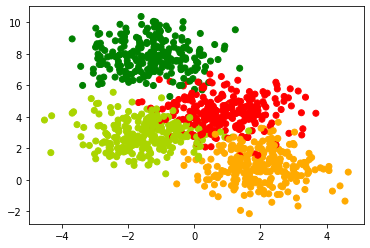

In [14]:
data , labels = make_blobs(n_samples=1000,n_features=2, centers=4,random_state=0)
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

#MultiClass Classification

In [15]:
X_train, X_val ,Y_train, Y_val = train_test_split(data, labels,stratify=labels,random_state = 0)
enc = OneHotEncoder()
Y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
Y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

In [0]:
W1 = np.random.randn(2,2)
W2 = np.random.randn(2,4)


# FeedForward Class 

In [0]:
class FeedForward:

  def __init__(self, W1, W2):
    self.params = {}
    self.params["W1"] = W1.copy()
    self.params["W2"] = W2.copy()
    self.params["B1"] = np.zeros((1,2))
    self.params["B2"] = np.zeros((1,4))
    self.num_layers = 2 
    self.update_params = {}
    self.prev_update_params = {}
    self.gradients={}

    for i in range(1,self.num_layers+1):
      self.update_params["v_w"+str(i)]=0
      self.update_params["v_b"+str(i)]=0
      self.update_params["m_w"+str(i)]=0
      self.update_params["m_b"+str(i)]=0
      self.prev_update_params["v_w"+str(i)]=0
      self.prev_update_params["v_b"+str(i)]=0

  def forward_activation(self,X):
    return 1.0 / ( 1.0 + np.exp(-X))
  
  def grad_activation(self,X):
    return X * (1 - X)
  
  def softmax(self,X):
    exps = np.exp(X)
    return exps / (np.sum(exps,axis=1).reshape(-1,1))
  
  def forward_pass(self,X,params = None):

    if params == None:
      params = self.params
    self.A1 = np.matmul(X, params["W1"]) + params["B1"] 
    self.H1 = self.forward_activation(self.A1)
    self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"]
    self.H2 = self.softmax(self.A2)
    return self.H2
  
  def grad(self, X,Y, params = None):
    if params is None:
      params = self.params 
      
    self.forward_pass(X, params)
    m = X.shape[0]
    self.gradients["dA2"] = self.H2 - Y # (N, 4) - (N, 4) -> (N, 4)
    self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"]) # (2, N) * (N, 4) -> (2, 4)
    self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis=0).reshape(1, -1) # (N, 4) -> (1, 4)
    self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T) # (N, 4) * (4, 2) -> (N, 2)
    self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
    self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"]) # (2, N) * (N, 2) -> (2, 2)
    self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis=0).reshape(1, -1) # (N, 2) -> (1, 2)

  def fit(self, X, Y, epochs = 100 , algo = "GD", display_loss =False, 
          eta =1 , mini_batch_size =100, eps = 1e-8, beta = 0.9, 
          beta1 =0.9, beta2 = 0.9, gamma = 0.9):
    
    if display_loss :
      loss = {}
    for iter_epoch in tqdm_notebook(range(epochs), total = epochs , unit = "Epoch"):
      m = X.shape[0]

      if algo =="GD":
        self.grad(X,Y)
        for i in range(1, self.num_layers + 1 ): 
          self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/m)
      
      elif algo == "MiniBatch":
        for k in range(0, m , mini_batch_size):
          self.grad(X[k:k+mini_batch_size],Y[k:k+mini_batch_size])
          for i in range(1, self.num_layers +1 ):
            self.params["W" + str(i)] -= eta * (self.gradients["dW" + str(i)]/ mini_batch_size)
            self.params["B" + str(i)] -= eta * (self.gradients["dB" + str(i)]/ mini_batch_size)
      
      elif algo == "Momentum":
        self.grad(X,Y)
        for i in range(1, self.num_layers + 1):
          self.update_params["v_w" + str(i)] = gamma * self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
          self.update_params["v_b" + str(i)] = gamma * self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
          self.params["W"+str(i)] -= self.update_params["v_w"+str(i)]
          self.params["B"+str(i)] -= self.update_params["v_b"+str(i)]

      elif algo == "NAG":
        temp_params = {}
        for i in range(1, self.num_layers +1 ):
          self.update_params["v_w"+str(i)] = gamma * self.prev_update_params["v_w"+str(i)]
          self.update_params["v_b"+str(i)] = gamma * self.prev_update_params["v_b"+str(i)]
          temp_params["v_w"+str(i)] = self.params["W"+str(i)] - self.update_params["v_w"+str(i)]
          temp_params["v_b"+str(i)] = self.params["B"+str(i)] - self.update_params["v_b"+str(i)]
        self.grad(X,Y,temp_params)
        for i in range(1, self.num_layers +1): 
          self.update_params["v_w" + str(i)] = gamma * self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
          self.update_params["v_b" + str(i)] = gamma * self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
          self.params["W"+str(i)] -= self.update_params["v_w"+str(i)]
          self.params["B"+str(i)] -= self.update_params["v_b"+str(i)]
        self.prev_update_params = self.update_params 
      
      elif algo == "AdaGrad":
        self.grad(X,Y)
        for i in range(1, self.num_layers + 1):
          self.update_params["v_w" + str(i)] += (self.gradients["dW" + str(i)]/m)**2 
          self.update_params["v_b" + str(i)] += (self.gradients["dW" + str(i)]/m)**2
          self.params["W"+str(i)] -= (eta / (np.sqrt(self.update["v_w"+str(i)])+eps))*(self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= (eta / (np.sqrt(self.update["v_b"+str(i)])+eps))*(self.gradients["dB"+str(i)]/m)
      
      elif algo == "RMSProp":
        self.grad(X,Y)
        for i in range(1, self.num_layers + 1):
          self.update_params["v_w" + str(i)] = beta * self.update_params["v_w" + str(i)] + (1 - beta) * (self.gradients["dW" + str(i)]/m)**2 
          self.update_params["v_b" + str(i)] = beta * self.update_params["v_b" + str(i)] + (1 - beta) * (self.gradients["dB" + str(i)]/m)**2
          self.params["W"+str(i)] -= (eta / (np.sqrt(self.update["v_w"+str(i)])+eps))*(self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= (eta / (np.sqrt(self.update["v_b"+str(i)])+eps))*(self.gradients["dB"+str(i)]/m)
      
      elif algo == "Adam":
        self.grad(X, Y)
        num_updates=0
        for i in range(1,self.num_layers+1):
          num_updates+=1
          self.update_params["m_w"+str(i)]=beta1*self.update_params["m_w"+str(i)]+(1-beta1)*(self.gradients["dW"+str(i)]/m)
          self.update_params["v_w"+str(i)]=beta2*self.update_params["v_w"+str(i)]+(1-beta2)*((self.gradients["dW"+str(i)]/m)**2)
          m_w_hat=self.update_params["m_w"+str(i)]/(1-np.power(beta1,num_updates))
          v_w_hat=self.update_params["v_w"+str(i)]/(1-np.power(beta2,num_updates))
          self.params["W"+str(i)] -=(eta/np.sqrt(v_w_hat)+eps)*m_w_hat
          
          self.update_params["m_b"+str(i)]=beta1*self.update_params["m_b"+str(i)]+(1-beta1)*(self.gradients["dB"+str(i)]/m)
          self.update_params["v_b"+str(i)]=beta2*self.update_params["v_b"+str(i)]+(1-beta2)*((self.gradients["dB"+str(i)]/m)**2)
          m_b_hat=self.update_params["m_b"+str(i)]/(1-np.power(beta1,num_updates))
          v_b_hat=self.update_params["v_b"+str(i)]/(1-np.power(beta2,num_updates))
          self.params["B"+str(i)] -=(eta/np.sqrt(v_b_hat)+eps)*m_b_hat
      if display_loss:
        Y_pred = self.predict(X)
        loss[iter_epoch] = log_loss(np.argmax(Y, axis=1), Y_pred)
    
    if display_loss:
      plt.plot(list(loss.values()), '-o', markersize=5)
      plt.xlabel('Epochs')
      plt.ylabel('Log Loss')
      plt.show()
      
  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()
      





  




In [0]:
def print_accuracy():    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))
    
    if False:
      plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
      plt.show()

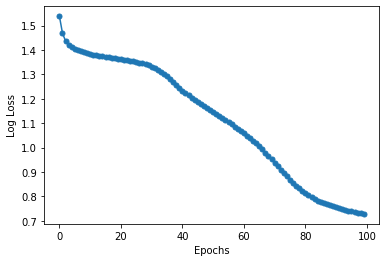

Training accuracy 0.7053
Validation accuracy 0.716
CPU times: user 344 ms, sys: 3.91 ms, total: 348 ms
Wall time: 354 ms


In [19]:
%%time
model = FeedForward(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=1, algo="GD", display_loss=True)
print_accuracy()

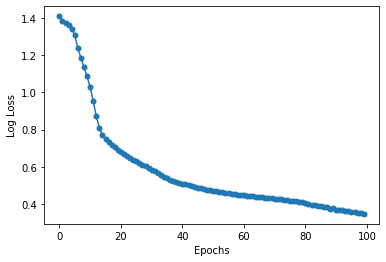

Training accuracy 0.8867
Validation accuracy 0.904
CPU times: user 384 ms, sys: 9.42 ms, total: 394 ms
Wall time: 413 ms


In [20]:
%%time
model = FeedForward(W1,W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=1, algo="MiniBatch", mini_batch_size=128, display_loss=True)
print_accuracy()

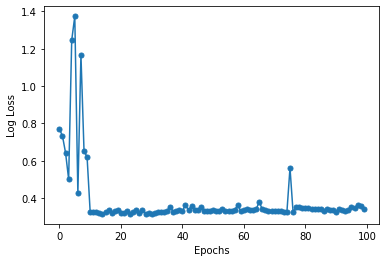

Training accuracy 0.8693
Validation accuracy 0.876
CPU times: user 1.03 s, sys: 11.8 ms, total: 1.04 s
Wall time: 1.07 s


In [22]:
%%time
model = FeedForward(W1,W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=1, algo="MiniBatch", mini_batch_size=8, display_loss=True)
print_accuracy()

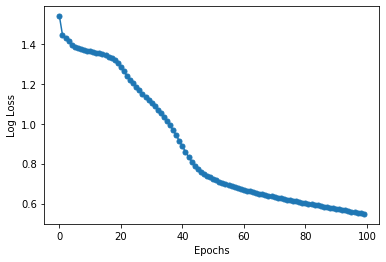

Training accuracy 0.8387
Validation accuracy 0.852
CPU times: user 311 ms, sys: 4.3 ms, total: 315 ms
Wall time: 352 ms


In [24]:
%%time
model = FeedForward(W1,W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=1, algo="Momentum", gamma=0.5, display_loss=True)
print_accuracy()

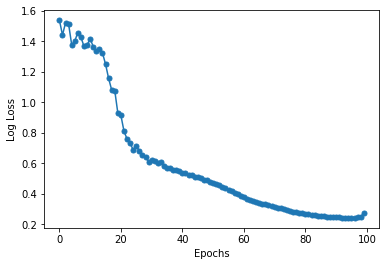

Training accuracy 0.8947
Validation accuracy 0.916
CPU times: user 343 ms, sys: 4.33 ms, total: 348 ms
Wall time: 380 ms


In [25]:
%%time 
model = FeedForward(W1,W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=1, algo="Momentum", gamma=0.9, display_loss=True)
print_accuracy()

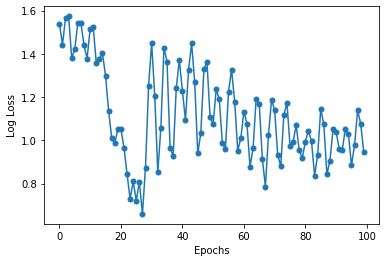

Training accuracy 0.6347
Validation accuracy 0.66
CPU times: user 320 ms, sys: 6.16 ms, total: 326 ms
Wall time: 335 ms


In [27]:
%%time
model = FeedForward(W1,W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=1, algo="Momentum", gamma=0.99, display_loss=True)
print_accuracy()

In [31]:
%%time
model = FeedForward(W1,W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=1, algo="NAG", gamma=0.9, display_loss=True)
print_accuracy()

KeyError: ignored